In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import os

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/IIT Docs/2nd Year/Semester 1/CM 2603 - Data Science Project/Data/Dataset/crop_classify",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5932 files belonging to 3 classes.


In [4]:
# Preprocess dataset
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
dataset = dataset.map(lambda x, y: (preprocess_input(x), y))

In [5]:
# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset = dataset.take(train_size)

In [6]:
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [7]:
# Create base model (MobileNetV2)
base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

In [8]:
# Freeze base model
base_model.trainable = False
# Add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

In [9]:
# Build the model
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=3)

Epoch 1/3
148/148 [==============================] - 60s 387ms/step - loss: 0.0566 - accuracy: 0.9791 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 2/3
148/148 [==============================] - 56s 377ms/step - loss: 0.0032 - accuracy: 0.9998 - val_loss: 0.0036 - val_accuracy: 0.9984
Epoch 3/3
148/148 [==============================] - 56s 376ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000


In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)

20/20 [==============================] - 12s 314ms/step - loss: 0.0022 - accuracy: 1.0000


In [13]:
print(f'Test accuracy: {accuracy}')

Test accuracy: 1.0


In [14]:
print("Accuracy: ", accuracy * 100, "%")

Accuracy:  100.0 %


In [15]:
# Save the model
model_version = max([int(i) for i in os.listdir("../mobilenetv2_models") + [0]]) + 1
model.save(f"../mobilenetv2_models/{model_version}")

INFO:tensorflow:Assets written to: ../mobilenetv2_models/1\assets


INFO:tensorflow:Assets written to: ../mobilenetv2_models/1\assets


In [16]:
model.save("../models/crop-id-model.h5")

D:\IIT Docs\2nd Year\Semester 1\CM 2603 - Data Science Project\Project\SampleFlask\PotatoDiseaseDetectionFlaskJinja\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 727ms/step


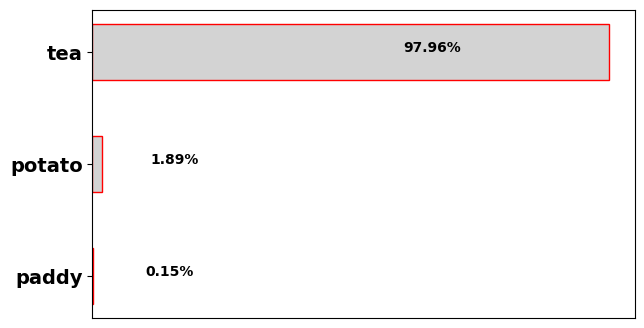

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

def prediction(img_path, model):
    class_names = ['paddy', 'potato', 'tea']

    # Load and preprocess the image
    my_image = load_img(img_path, target_size=(256, 256))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, 0)
    my_image = my_image.astype('float32')/ 255

    # Make predictions
    prediction_output = model.predict(my_image)

    # Plot the predictions
    fig = plt.figure(figsize=(7, 4))
    plt.barh(class_names, prediction_output[0], color='lightgray', edgecolor='red', linewidth=1, height=0.5)

    for index, value in enumerate(prediction_output[0]):
        plt.text(value / 2 + 0.1, index, f"{100 * value:.2f}%", fontweight='bold')

    plt.xticks([])
    plt.yticks([0, 1, 2], labels=class_names, fontweight='bold', fontsize=14)
    plt.savefig('pred_img.png', bbox_inches='tight')
    plt.show()

# Load pre-trained model
model = tf.keras.models.load_model("../models/crop-id-model.h5")

# Path to the image for prediction
img_path = "C:/Users/ASUS/Desktop/test img/UNADJUSTEDNONRAW_thumb_7d.jpg"

# Make predictions
prediction(img_path, model)